# Recursive Quantum Approximate Optimization Algorithm

In this notebook, we provide a short introduction to recursive QAOA, and demonstrate how this technique is implemented in the OpenQAOA workflows, by solving the Sherrington-Kirkpatrick Hamiltonian with $\pm 1$ weights.

### A brief introduction to RQAOA

Recursive QAOA (RQAOA) is an iterative variant of QAOA, first introduced by Bravyi et. al in [1] and further explored in [2,3]. 

This technique consists in recursively reducing the size of the problem by running QAOA. At each step, the QAOA output distribution is used to compute the expectation values 

$$
\mathcal{M}_{i} = \langle Z_{i} \rangle \qquad \qquad \qquad \qquad \qquad \mathcal{M}_{ij} = \langle Z_{i}Z_{j} \rangle,
$$

associated with the terms present in the Hamiltonian. Note that, by definition, these quantities are bounded between -1 and 1. The expectation values are then ranked according to their magnitude $|\mathcal{M}_{(i,ij)}|$. In its original formulation, the highest ranked value is selected. This value is then utilized to eliminate a qubit from the Hamiltonian. This is done by first, performing integer rounding of the expectation value, i.e. $\mathcal{M}_{(i,ij)} \rightarrow \textrm{sign}(\mathcal{M}_{(i,ij)})$, then transforming the rounded value into a constraint on the respective\ qubits

$$
Z_{i} \rightarrow \textrm{sign}(\mathcal{M}_{(i)}) \qquad \qquad \qquad \qquad \qquad \langle Z_{i} Z_{j} \rangle \rightarrow \textrm{sign}(\mathcal{M}_{(ij)}),
$$

and last, inserting the constraint into the Hamiltonian, effectively reducing the size of the problem by one qubit. Using the reduced Hamiltonian, QAOA is run again and the same procedure is followed. Once the reduced problem reaches a predefined cutoff size, it is solved exactly solved via classical methods. The final answer is then reconstructed by re-inserting the eliminated qubits into the classical solution following the appropriate order.

This version of RQAOA is included in OpenQAOA. Additionally, OpenQAOA incorporates RQAOA from two different generalized version of these procedure, which enable multiple qubit eliminations during the recursive process. These strategies are denoted as `custom` and `adaptive` [4], in accordance with the precise concept under which the elimination method takes place. In a nutshell, they are described as follows:


* The ``custom`` strategy allows the user to define the number of eliminations to be performed at each step. This defined by the parameter ``steps``. If the parameter is set as an integer, the algorithm will use this value as the number of qubits to be eliminated at each step. Alternatively, it is possible to pass a list, which specifies the number of qubits to be eliminated at each step. For ``steps = 1``, the algorithm reduces to the original form of RQAOA presented in [1].

* The ``adaptive`` strategy adaptively selects how many qubits to eliminate at each step. The maximum number of allowed eliminations is given by the parameter ``n_max``. At each step, the algorithm selects the top ``n_max+1`` expectation values (ranked in magnitude), computes the mean among them, and uses the ones lying above it for qubit elimination. This corresponds to a maximum of ``n_max`` possible elimination per step. For ``n_max= 1``, the algorithm reduces to the original form of RQAOA presented in [1].

**NOTE**: The specific performance of these generalizations is currently under investigation. In particular, the development of Adaptive RQAOA is associated with an internal research project at Entropica Labs to be released publicly in the near future [4]. We make these strategies already available to the community in order to strengthen the exploration of more complex elimination schemes for RQAOA, beyond its original formulation [1].

# References

[1] S. Bravyi, A. Kliesch, R. Koenig, and E. Tang, [Physical Review Letters 125, 260505 (2020)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.125.260505) \
[2] S. Bravyi, A. Kliesch, R. Koenig, and E. Tang, [(2020), 10.22331/q-2022-03-30-678](https://quantum-journal.org/papers/q-2022-03-30-678/) \
[3] D. J. Egger, J. Marecek, and S. Woerner, [Quantum 5, 479 (2021)](https://doi.org/10.22331/q-2021-06-17-479) \
[4] E. I. Rodríguez Chiacchio, V. Sharma, E. Munro (Work in progress) 

In [ ]:
# pip install openqaoa

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from openqaoa.workflows.optimizer import RQAOA, QAOA
from openqaoa.problems import QUBO
from openqaoa.utilities import ground_state_hamiltonian
from openqaoa.qaoa_parameters import Hamiltonian
from openqaoa.devices import create_device

## Setting the problem

Let us now do a walk through the whole process for the Sherrington-Kirkpatrick model. This corresponds to a fully-connected system, where we choose the couplings $J_{ij}$ to be of magnitude 1, but with a randomly assigned signs. The workflow requires us to define the problem as an instance of the ``QUBO`` (Quadratic Unconstrained Binary Optimization) class, which is easily done by defining the connectivity of the problem, and the and the couplings.

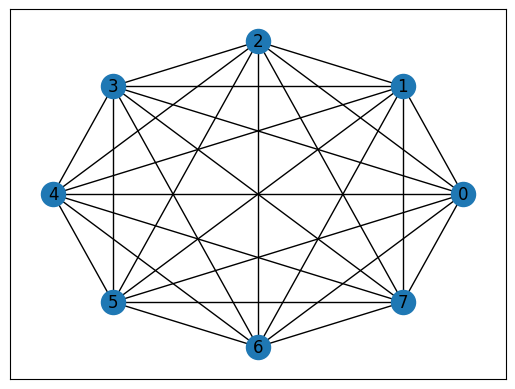

In [3]:
# Number of qubits
n_qubits = 8

# Define fully-connected terms
terms = [(i,j) for j in range(n_qubits) for i in range(j)]

# Assign coupling signs at random
rng = np.random.default_rng(42)
weights = [(-1)**np.round(rng.random()) for _ in range(len(terms))]

# Define QUBO problem
sk = QUBO(n_qubits,terms,weights)

# Plot geometry
sk_graph = nx.Graph()
sk_graph.add_edges_from(terms)
nx.draw_networkx(sk_graph, pos = nx.kamada_kawai_layout(sk_graph))

## Run RQAOA on a local simulator 

 We now demonstrate the full RQAOA workflow and how to run it on AWS (or any other!) devices

In [4]:
# Define an instance of the RQAOA class
r =  RQAOA()

In [5]:
# Set up RQAOA properties

# Cutoff size at which to solve things classically
n_cutoff = 3

# Number of eliminations per step
n_steps = 1

# Set instance parameters
r.set_rqaoa_parameters(n_cutoff = n_cutoff, steps = n_steps, rqaoa_type = 'custom')

In [6]:
# Set up the QAOA properties

# Set the properties you want - These values are actually the default ones!
r.set_circuit_properties(p=1, param_type='standard', init_type='ramp', mixer_hamiltonian='x')

# Define the device you want to run your problem on using the create_device() function - Here we choose the local AWS simulator
device = create_device(location='local', name='vectorized')
r.set_device(device)

# Set the classical method used to optimiza over QAOA angles and its properties
r.set_classical_optimizer(method='cobyla', maxiter=200)

In [7]:
# Compile problem instance 
r.compile(sk)

In [8]:
# Solve problem with RQAOA
r.optimize()

In [9]:
# Extract results
result = r.results

 The results show the final solution of the problem, the output from the classical solution on the reduced problem, the set of eliminations performed (on which pair and which correlation), the schedule followed (the number of eliminations at each step), the total number of recursive steps it took to reach the cutoff size and the all the information regarding the problem and QAOA run in the intermediate steps.

In [10]:
result

{'solution': {'10001000': -12.0, '01110111': -12.0},
 'classical_output': {'minimum_energy': -3.0,
  'optimal_states': ['100', '011']},
 'elimination_rules': [[{'pair': (2, 4), 'correlation': -1.0}],
  [{'pair': (0, 4), 'correlation': -1.0}],
  [{'pair': (0, 4), 'correlation': -1.0}],
  [{'pair': (2, 3), 'correlation': 1.0}],
  [{'pair': (2, 3), 'correlation': 1.0}]],
 'schedule': [1, 1, 1, 1, 1],
 'number_steps': 5,
 'intermediate_steps': [{'counter': 0,
   'problem': <openqaoa.problems.qubo.QUBO at 0x7f39b341f460>,
   'qaoa_results': <openqaoa.optimizers.result.Result at 0x7f3a13dfb7f0>,
   'exp_vals_z': array([0., 0., 0., 0., 0., 0., 0., 0.]),
   'corr_matrix': array([[ 0.        ,  0.12081413, -0.2361811 ,  0.04850827,  0.29105518,
           -0.2361811 , -0.12081413, -0.18130702],
          [ 0.        ,  0.        ,  0.18130702, -0.12081413,  0.2361811 ,
            0.18130702,  0.18130702,  0.12081413],
          [ 0.        ,  0.        ,  0.        ,  0.2361811 , -0.35154807,


 From the intermediate steps, we can extract useful properties such as the cost optimization, the shape of the system, or the correlation matrix at that step. The ``r.results`` object has some methods that help to get the intermediate steps: ``.get_qaoa_results(step)``, ``.get_problem(step)``, ``plot_corr_matrix(step)``, among my others (see documentation [ADD LINK]).

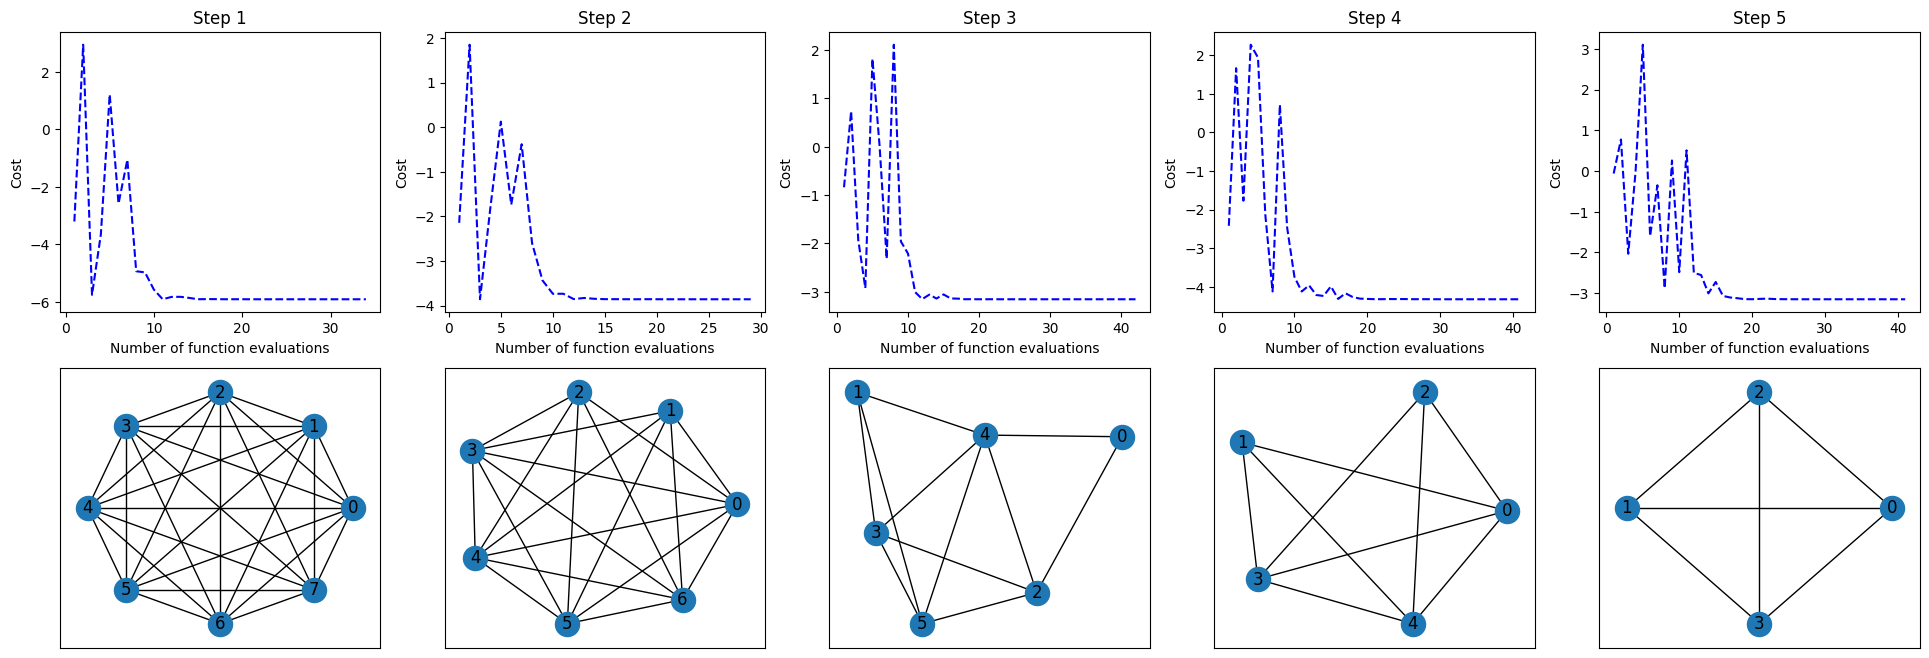

In [12]:
# Retrieve intermediate problem and QAOA optimization progress

# Number of recursive steps
num_steps = result['number_steps']

fig, ax = plt.subplots(2,num_steps, figsize = (24,8))

for i in range(num_steps):
    
    # Get the QUBO problem and QAOA result object for the last step
    qaoa_results = result.get_qaoa_results(step = i)
    qubo_problem = result.get_problem(step = i)
    
    # Extract problem graph
    qubo_graph = nx.Graph()
    qubo_graph.add_edges_from(qubo_problem.terms)
    
    # Plot cost optimization
    qaoa_results.plot_cost(ax = ax[0][i])
    ax[0][i].set_title(f'Step {i+1}')
    ax[0][i].get_legend().remove()
    
    # Plot problem graph
    nx.draw_networkx(qubo_graph, pos = nx.kamada_kawai_layout(qubo_graph), ax = ax[1][i])

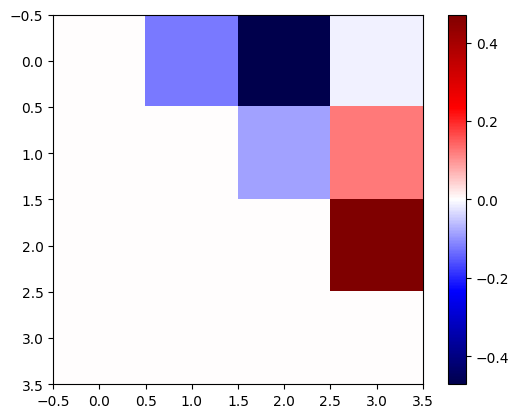

In [13]:
# Plot the correlation matrix of the last step
result.plot_corr_matrix(step = 4, cmap = 'seismic')

Finally, to check the quality of our results, we compute the exact solution, which can be done for any Hamiltonian of reasonable size using the OpenQAOA utility function ``ground_state_hamiltonian``. To use this function we define the problem as an instance of the ``Hamiltonian`` class, using the ``classical_hamiltonian`` method (given that our Hamiltonian is only composed of $Z$ operators). This class is widely used across OpenQAOA to generate mixer and cost Hamiltonians that define the QAOA structure.

In [14]:
# Get RQAOA solutions
solutions = result.get_solution()
states = list(solutions.keys())
energy = list(solutions.values())[0]

# Obtain exact solution for comparison

# Define Hamiltonian object from terms and weights
hamiltonian = Hamiltonian.classical_hamiltonian(terms,weights,constant = 0)

# Compute the exact result
exact_energy, ground_state_strings = ground_state_hamiltonian(hamiltonian)

print(f'The solution found by RQAOA for is energy = {energy} and ground states = {states}\n')

print(f'The exact energy is {exact_energy} and the solutions are {ground_state_strings}')

The solution found by RQAOA for is energy = -12.0 and ground states = ['10001000', '01110111']

The exact energy is -12.0 and the solutions are ['10001000', '11001010', '00110101', '01110111']


As we can see, for this simple problem, RQAOA was able to to find two out of the four ground states!

## Run RQAOA on a QPU

To run RQAOA, using OpenQAOA, now on a real quantum device, one simply needs to change the device parameters when defining the RQAOA instance, and voilá!

In [ ]:
# Define an instance of the RQAOA class
r =  RQAOA()

# Set instance parameters
r.set_rqaoa_parameters(n_cutoff = 3, steps = 1, rqaoa_type = 'custom')

# Set the properties you want - These values are actually the default ones!
r.set_circuit_properties(p=1, param_type='standard', init_type='ramp', mixer_hamiltonian='x')

# Set the classical method used to optimiza over QAOA angles and its properties
r.set_classical_optimizer(method='cobyla', maxiter=200)

In [ ]:
# Set a quantum device to run our instance
device = create_device(location=, name=)
r.set_device(device)